## Import all what we need.

In [1]:
# encoding: utf-8
import os
import bz2
import csv
import glob
import time
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from numba import njit
from io import StringIO
import matplotlib.pyplot as plt
import threading, multiprocessing

## The Input File Path and Parameters


<table><tr><td bgcolor=skyblue><font size=24> Could be changed ! </font></td></tr></table>

In [2]:
#########################################################
inp_filepath = '/home/jingxin/PyExoCross/input/NO_exomol.inp'
read_path = '/mnt/data/exomol/exomol3_data/'

save_path = '/home/jingxin/data/pyexocross/'
if os.path.exists(save_path):
    pass
else:
    os.makedirs(save_path, exist_ok=True)

ratio = 1.0
ratio_air = 0.7
ratio_self = 0.3
cutoff = 25.0
threshold = 1e-30
#########################################################

## Report time

In [3]:
class Timer:    
    def start(self):
        self.start_CPU = time.process_time()
        self.start_sys = time.time()
        return self

    def end(self, *args):
        self.end_CPU = time.process_time()
        self.end_sys = time.time()
        self.interval_CPU = self.end_CPU - self.start_CPU
        self.interval_sys = self.end_sys - self.start_sys
        print('{:25s} : {}'.format('Running time on CPU', self.interval_CPU), 's')
        print('{:25s} : {}'.format('Running time on system', self.interval_sys), 's')

## Read Information from Input File

In [4]:
def inp_para(inp_filepath):
    
    inp_col_name = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9','c10']
    inp_df = pd.read_csv(inp_filepath, sep='\\s+', names=inp_col_name, header=None)
    col0 = inp_df['c0']
    database = inp_df[col0.isin(['Database'])]['c1'].values[0]
    molecule = inp_df[col0.isin(['Molecule'])]['c1'].values[0]
    isotopologue = inp_df[col0.isin(['Isotopologue'])]['c1'].values
    dataset = inp_df[col0.isin(['Dataset'])]['c1'].values
    mol_iso_id = int(inp_df[col0.isin(['mol_iso_id'])]['c1'])
    mass = float(inp_df[col0.isin(['mass'])]['c1'])    # ExoMol mass (kg)
    T = int(inp_df[col0.isin(['Temperature'])]['c1'])
    P = float(inp_df[col0.isin(['Pressure'])]['c1'])
    min_wn = float(inp_df[col0.isin(['Range'])]['c1'])
    max_wn = float(inp_df[col0.isin(['Range'])]['c2'])
    N_point = int(inp_df[col0.isin(['Npoints'])]['c1'])
    abs_emi = inp_df[col0.isin(['AbsorptionOREmission'])]['c1'].values[0]
    profile = inp_df[col0.isin(['Profile'])]['c1'].values[0]
    wn_wl = inp_df[col0.isin(['Wavenumber(wn)/wavelength(wl)'])]['c1'].values[0]
    saveplots = inp_df[col0.isin(['SavePlots'])]['c1'].values[0]
    savexsecs = inp_df[col0.isin(['SaveXsecs'])]['c1'].values[0]

    molecule_id = int(mol_iso_id/10)
    isotopologue_id = mol_iso_id - molecule_id * 10
    isometa_url = 'https://hitran.org/docs/iso-meta/'
    iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
    iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
    abundance = float(iso_meta_row['Abundance'][0].replace('\xa0×\xa010','E'))
    
    return database, molecule, isotopologue, dataset, T, P, min_wn, max_wn, N_point, abs_emi, profile, wn_wl, saveplots, savexsecs, molecule_id, isotopologue_id, abundance, mass


## Constants and Parameters

In [5]:
# Parameters for calculating.
import astropy.constants as ac
(database, molecule, isotopologue, dataset, T, P, min_wn, max_wn, N_point, abs_emi, profile, wn_wl, 
 saveplots, savexsecs, molecule_id, isotopologue_id, abundance, mass) = inp_para(inp_filepath)
T_ref = 296.0                       # Reference temperature is 296 K.
P_ref = 1.0                         # Reference pressure is 1 atm.
N_A = ac.N_A.value                  # Avogadro number (1/mol)
h = ac.h.to('J s').value            # Planck's const (J s)
c = ac.c.to('cm/s').value           # Velocity of light (cm/s)
kB = ac.k_B.to('J/K').value         # Boltzmann's const (J/K)
R = ac.R.to('J / (K mol)').value    # Gas constant (J/(K mol))
c2 = h * c / kB                     # Second radiation constant (cm K)

c2_T = c2 / T                       # c2 / T (cm)
c2_T_ref = c2 / T_ref               # c2 / T_ref (cm)
pi_c_8 = 1 / (8 * np.pi * c)        # 8 * pi * c (s/cm)

## Read ExoMol Format Input File

Read the parameters of the linelist in ExoMol format text file. Return the dataframe of the linelist data for the following calculations.

### Read States File

In [6]:
def read_all_states(read_path):
    
    s_df = dict()
    states_df = pd.DataFrame()
    states_filenames = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset 
                                  + '/' + isotopologue + '__' + dataset + '.states.bz2')[0])

    for states_filename in states_filenames:
        s_df[states_filename] = pd.read_csv(states_filename, compression='bz2', sep='\s+', header=None,
                                            chunksize=100000, iterator=True, low_memory=False)
        for chunk in s_df[states_filename]:
            states_df = pd.concat([states_df, chunk])
            
    pd.set_option("display.max_columns",30)                           
    return(states_df)

In [7]:
read_all_states(read_path)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,0.000000,6,0.5,0.000105,inf,-0.000767,+,e,X2Pi,0,1,-0.5,0.5,EH,0.000000
1,2,1876.076228,6,0.5,0.000105,0.083086,-0.000767,+,e,X2Pi,1,1,-0.5,0.5,EH,1876.080573
2,3,3724.066346,6,0.5,0.000105,0.042467,-0.000767,+,e,X2Pi,2,1,-0.5,0.5,EH,3724.063754
3,4,5544.020643,6,0.5,0.000105,0.028936,-0.000767,+,e,X2Pi,3,1,-0.5,0.5,EH,5544.019791
4,5,7335.982597,6,0.5,0.000105,0.022179,-0.000767,+,e,X2Pi,4,1,-0.5,0.5,EH,7335.982588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30806,30807,51437.214745,1104,183.5,85.000000,2.263500,-0.005226,-,e,X2Pi,0,-1,-0.5,-1.5,Sh,51436.924721
30807,30808,51423.819795,1110,184.5,86.000000,2.259500,0.005286,+,e,X2Pi,0,1,-0.5,0.5,Sh,51423.355496
30808,30809,51924.380929,1110,184.5,86.000000,2.140000,-0.005198,+,e,X2Pi,0,1,0.5,1.5,Sh,51924.090905
30809,30810,51422.660483,1110,184.5,86.000000,2.260400,0.005295,-,f,X2Pi,0,-1,0.5,-0.5,Sh,51422.346275


### Read transitions File

In [8]:
def get_transfiles(read_path):
    # Get all the transitions files from the folder including the older version files which are named by vn(version number).
    trans_filepaths_all = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')[0])
    num_transfiles_all = len(trans_filepaths_all)    # The number of all transitions files including the older version files.
    trans_filepaths = []    # The list of the lastest transitions files.
    for i in range(num_transfiles_all):
        split_version = trans_filepaths_all[i].split('__')[-1].split('.')[0].split('_')    # Split the filenames.
        num = len(split_version)
        # There are three format filenames.
        # The lastest transitions files named in two formats:
        # 1. Filenames are named with the name of isotopologue and dataset. 
        #    End with .trans.bz2.
        #    e.g. 14N-16O__XABC.trans.bz2'
        # 2. Filenames are named with the name of isotopologue and dataset. 
        #    Also have the range of wavenumbers xxxxx-yyyyy.
        #    End with .trans.bz2.
        #    e.g. 1H2-16O__POKAZATEL__00000-00100.trans.bz2
        # 3. The older version transitions files are named with vn(version number) based on the first format of the lastest files.
        #    e.g. 14N-16O__XABC_v2.trans.bz2
        # After split the filenames:
        # The first format filenames only leave the dataset name, e.g. XABC.
        # The second format filenames only leave the range of the wavenumber, e.g. 00000-00100.
        # The third format filenames leave two parts(dataset name and version number), e.g. XABC and v2.
        # This program only process the lastest data, so extract the filenames named by the first two format.
        if num == 1:        
            trans_filepaths.append(trans_filepaths_all[i])
    return(trans_filepaths)   

In [9]:
def read_all_trans(read_path):
    
    t_df = dict()
    trans_df = pd.DataFrame()
    trans_col_name = ['u', 'l', 'A', 'v']
    trans_filepaths = get_transfiles(read_path)
    #trans_filepaths = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')[0])

    for trans_filename in tqdm(trans_filepaths):
        t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None,
                                           names=trans_col_name, chunksize=100000, iterator=True, low_memory=False)
        for chunk in t_df[trans_filename]:
            trans_df = pd.concat([trans_df,chunk])
            
    pd.set_option("display.max_columns",30)                           
    return(trans_df)
    

In [ ]:
read_all_trans(read_path)

### Read Partition Function File

In [10]:
def read_web_pf(T_ref, T):
    
    pf_url = ('http://www.exomol.com/db/' + molecule + '/' + isotopologue + '/' + dataset 
              + '/' + isotopologue + '__' + dataset + '.pf')[0]
    pf_content = requests.get(pf_url).text
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(StringIO(pf_content), sep='\\s+', names=pf_col_name, header=None)
    Q_ref = pf_df['Q'][T_ref-1]
    Q = pf_df['Q'][T-1]

    return(Q_ref, Q)

In [11]:
def read_pf(read_path, T_ref, T):
    
    pf_filename = (read_path + molecule + '/' + isotopologue + '/' + dataset 
                   + '/' + isotopologue + '__' + dataset + '.pf')[0]
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(pf_filename, sep='\\s+', names=pf_col_name, header=None)
    Q_ref = pf_df['Q'][T_ref-1]
    Q = pf_df['Q'][T-1]

    return(Q_ref, Q)

In [12]:
def read_broad(read_path):
    broad_col_name = ['code', 'gamma_L', 'n_air', 'Jpp']
    broad_path = (read_path + molecule + '/' + isotopologue + '/' + isotopologue + '__air.broad')[0]
    if not os.path.exists:
        raise ImportError('The boradening file ' + broad_path + ' does not exist.')
    broad_df = pd.read_csv(broad_path, sep='\s+', names=broad_col_name, header=None, engine='python')
    return(broad_df)

In [13]:
def all_linelist(read_path):
    states_df = read_all_states(read_path)
    trans_df = read_all_trans(read_path)
    
    id_u = trans_df['u'].values
    states_df.set_index([0], inplace=True, drop=False)
    states_u_df = states_df.loc[id_u]
    linelist_df = pd.DataFrame()
    linelist_df['u'] = trans_df['u']
    linelist_df['l'] = trans_df['l']
    linelist_df['A'] = trans_df['A']
    linelist_df['v'] = trans_df['v']
    linelist_df['Ep'] = states_u_df[1].values
    linelist_df['gp'] = states_u_df[2].values
    
    return linelist_df


In [ ]:
all_linelist_df = all_linelist(read_path)
all_linelist_df

# Parition Function


In [ ]:
def calculate_partition(En, gn, T):
    partition_func = np.sum(gn * np.exp(-c2 * En / T))
    return(partition_func)

In [ ]:
# Partition function
def exomol_partition_func(read_path, Ntemp, Tmax):
    
    states_df = read_all_states(read_path)
    En = states_df[1]
    gn = states_df[2]
    pf_list = []

    for T in tqdm(range(Ntemp, Tmax+1, Ntemp)):
        partition_func = calculate_partition(En, gn, T)
        pf_list.append(str(format(T, '8.1f') + ' ' + format(partition_func, '15.4f')))
        
    pf_folder = save_path + '/partition/'
    if os.path.exists(pf_folder):
        pass
    else:
        os.makedirs(pf_folder, exist_ok=True)
    pf_path = (pf_folder + isotopologue + '__' + dataset + '.pf')[0]
 
    with open(pf_path, 'w') as pf_file:
        for pf in pf_list:
            pf_file.write(pf + '\n')
        pf_file.close()

    print('Partition function has been saved!')  


In [ ]:
Ntemp = 1
Tmax = int(5000.00)
t = Timer()
t.start()
exomol_partition_func(read_path, Ntemp, Tmax)
t.end()


# Cooling Function

In [ ]:
@njit(parallel=True, fastmath=True)
def calculate_cooling(A, v, Ep, gp, T, Q):
    cooling_func = np.sum(A * h * c * v * gp * np.exp(-c2 * Ep / T)) / (4 * np.pi * Q) * 1e7
    return(cooling_func)

In [ ]:
# Cooling function
def exomol_cooling_func(read_path, Ntemp, Tmax):
    
    linelist_df = all_linelist(read_path)
    A = linelist_df['A'].values
    v = linelist_df['v'].values
    Ep = linelist_df['Ep'].values      # Lower state energy
    gp = linelist_df['gp'].values      # Total degeneracy of lower state 
    cf_list = []
    
    for T in tqdm(range(Ntemp, Tmax+1, Ntemp)):
        Q_ref, Q = read_pf(read_path, T_ref, T)
        cooling_func = calculate_cooling(A, v, Ep, gp, T, Q)
        cf_list.append(str(format(T, '8.1f') + ' ' + format(cooling_func, '20.8E')))

    cf_folder = save_path + '/cooling/'
    if os.path.exists(cf_folder):
        pass
    else:
        os.makedirs(cf_folder, exist_ok=True)  
    cf_path = (cf_folder + isotopologue + '__' + dataset + '.cooling')[0]
    
    with open(cf_path, 'w') as cf_file:
        for cf in cf_list:
            cf_file.write(cf + '\n')
        cf_file.close()

    print('Cooling function has been saved!')   
    


In [ ]:
Ntemp = 1
Tmax = int(500.00)
t = Timer()
t.start()
exomol_cooling_func(read_path, Ntemp, Tmax)
t.end()

# Lifetime

In [ ]:
# Lifetime
def exomol_lifetime(read_path):
    
    states_df = read_all_states(read_path)
    trans_df = read_all_trans(read_path)
    sum_A = trans_df.groupby('u')['A'].sum()
    lifetime = 1 / sum_A
    lt_df = lifetime.map('{: >12.4E}'.format).reset_index()
    states_trans_df = pd.concat([states_df[0], lt_df['u']])
    states_trans_df = states_trans_df.drop_duplicates(keep=False)
    add_u = pd.DataFrame()
    add_u['u'] = states_trans_df
    add_u['A'] = '  Inf       '
    lifetime_df = pd.concat([lt_df, add_u], ignore_index=True)
    lifetime_df.sort_values('u',inplace=True)
    
    lf_folder = save_path + '/lifetime/'
    if os.path.exists(lf_folder):
        pass
    else:
        os.makedirs(lf_folder, exist_ok=True)  
    lf_path = (lf_folder + isotopologue + '__' + dataset + '.life')[0]
    lifetime_df['A'].to_csv(lf_path, header=None, index=False, chunksize = 1000)

    print('lifetime has been saved!')   
    return(lifetime_df)

In [ ]:
exomol_lifetime(read_path)

# Specific Heat

In [ ]:
@njit(parallel=True, fastmath=True)
def calculate_specific_heat(En, gn, T):
    pf = np.sum(gn * np.exp(-c2 * En / T))  
    pfp = np.sum(gn * np.exp(-c2 * En / T) * (c2 * En / T))
    pfpp = np.sum(gn * np.exp(-c2 * En / T) * (c2 * En / T) ** 2)
    specificheat_func = R * (pfpp / pf - (pfp / pf) ** 2) + 2.5 * R
    return(specificheat_func)

In [ ]:
# Specific heat
def exomol_specificheat_func(read_path, Ntemp, Tmax):

    states_df = read_all_states(read_path)
    En = states_df[1].values
    gn = states_df[2].values
    cp_list = []
    
    for T in tqdm(range(200, Tmax+1, Ntemp)):
        specificheat_func = calculate_specific_heat(En, gn, T)
        cp_list.append(str(format(T, '8.1f') + ' ' + format(specificheat_func, '15.4f')))
        
    cp_folder = save_path + '/specific_heat/'
    if os.path.exists(cp_folder):
        pass
    else:
        os.makedirs(cp_folder, exist_ok=True)  
    cp_path = (cp_folder + isotopologue + '__' + dataset + '.cp')[0]
 
    with open(cp_path, 'w') as cp_file:
        for cp in cp_list:
            cp_file.write(cp + '\n')
        cp_file.close()

    print('Specific heat has been saved!')  


In [ ]:
Ntemp = 1
Tmax = int(5000.0)
t = Timer()
t.start()
exomol_specificheat_func(read_path, Ntemp, Tmax)
t.end()


## Line Profile

In [14]:
@njit(parallel=True, fastmath=True)
def Doppler_HWHM (v, mass, T):
    '''Return the Doppler half-width at half-maximum (HWHM) -- alpha.'''
    alpha = np.sqrt(2 * kB * T * np.log(2) / mass) * v / c
    return alpha

In [15]:
@njit(parallel=True, fastmath=True)
def Lorentzian_HWHM (T, P, n_air, gamma_L):
    '''Return the Lorentzian half-width at half-maximum (HWHM) -- gamma.'''
    gamma = gamma_L * ratio * (T_ref / T)**n_air * (P / P_ref)
    
    return gamma

In [16]:
@njit(parallel=True, fastmath=True)
def Gaussian_FWHM (alpha):
    f_G = 2 * alpha * np.sqrt(2 * np.log(2))
    return(f_G)

In [17]:
@njit(parallel=True, fastmath=True)
def Lorentzian_FWHM (gamma):
    f_L = 2 * gamma
    return(f_L)

In [18]:
@njit(parallel=True, fastmath=True)
def Gaussian_profile(dv, alpha):
    '''Return Gaussian line profile at dv with HWHM alpha.'''
    alpha = alpha * 2
    Gaussian_profile = np.sqrt(np.log(2) / np.pi) / alpha * np.exp(-np.log(2) * (dv / alpha)**2)
    return Gaussian_profile

In [19]:
@njit(parallel=True, fastmath=True)
def Lorentzian_profile(dv, gamma):
    '''Return Lorentzian line profile at dv with HWHM gamma.'''
    #gamma = gamma * 2
    Lorentzian_profile = gamma / np.pi / (dv**2 + gamma**2)
    return Lorentzian_profile


In [20]:
def scipy_Voigt_profile(dv, alpha, gamma):
    '''Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.'''
    from scipy.special import voigt_profile
    return voigt_profile(dv, alpha, gamma)

In [21]:
def scipy_wofz_Voigt_profile(dv, alpha, gamma):
    '''Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.'''
    from scipy.special import wofz
    sigma = alpha / np.sqrt(2 * np.log(2))
    scipy_wofz_Voigt_profile = np.real(wofz((dv + 1j*gamma)/sigma/np.sqrt(2))) / sigma / np.sqrt(2*np.pi)
    return scipy_wofz_Voigt_profile

In [22]:
@njit(parallel=True, fastmath=True)
def width_Voigt_profile(f_G, f_L):
    '''
    Return the full width at half maximum (FWHM) of the Voigt profile which can
    be found from the widths of the associated Gaussian and Lorentzian widths.

    '''
    width_Voigt_profile = 0.5346 * f_L + np.sqrt(0.2166 * f_L**2 + f_G**2)
    return width_Voigt_profile

In [23]:
@njit(parallel=True, fastmath=True)
def pseudo_Voigt_profile(f_G, f_L):
    '''Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.'''
    pseudo_Voigt_profile = (f_G**5+2.69269*f_G**4*f_L+2.42843*f_G**3*f_L**2+4.47163*f_G**2*f_L**3+0.07842*f_G*f_L**4+f_L**5)**0.2
    return pseudo_Voigt_profile

In [24]:
@njit(parallel=True, fastmath=True)
def pseudo_Voigt_FWHM_profile(dv, alpha, gamma):
    '''
    Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.
    f is the total FWHM parameter.
    n is a function of Lorentz (f_L), Gaussian (f_G) and total (f) full width at half maximum (FWHM) parameters.
    
    '''
    f_G = 2 * alpha * np.sqrt(2 * np.log(2))
    f_L = 2 * gamma
    f = (f_G**5 + 2.69269*f_G**4*f_L + 2.42843*f_G**3*f_L**2 + 4.47163*f_G**2*f_L**3 + 0.07842*f_G*f_L**4 + f_L**5)**0.2
    n = 1.36603*(f_L/f) - 0.47719*(f_L/f)**2 + 0.11116*(f_L/f)**3
    pseudo_fwhm_Voigt_profile = n*Lorentzian_profile(dv,f/2) + (1-n)*Gaussian_profile(dv,f/2)
    return pseudo_fwhm_Voigt_profile

In [25]:
@njit(parallel=True, fastmath=True)
def pseudo_Voigt_FWHM_profile(dv, f_G, f_L):
    '''
    Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.
    f is the total FWHM parameter.
    n is a function of Lorentz (f_L), Gaussian (f_G) and total (f) full width at half maximum (FWHM) parameters.
    
    '''
    f = (f_G**5 + 2.69269*f_G**4*f_L + 2.42843*f_G**3*f_L**2 + 4.47163*f_G**2*f_L**3 + 0.07842*f_G*f_L**4 + f_L**5)**0.2
    n = 1.36603*(f_L/f) - 0.47719*(f_L/f)**2 + 0.11116*(f_L/f)**3
    pseudo_fwhm_Voigt_profile = n*Lorentzian_profile(dv,f/2) + (1-n)*Gaussian_profile(dv,f/2)
    return pseudo_fwhm_Voigt_profile

## Calculate Cross Sections

In [26]:
@njit(parallel=True, fastmath=True)
def cal_v(Epp, Ep):
    v = np.abs(Epp - Ep)
    return(v)

In [27]:
@njit(parallel=True, fastmath=True)
def cal_abscoefs(v, gp, A, Epp, Q, abundance):
    abscoef = gp * A * np.exp(- c2_T * Epp) * (1 - np.exp(- c2_T * v)) * pi_c_8 / (v ** 2) / Q * abundance   
    return (abscoef)

In [28]:
@njit(parallel=True, fastmath=True)
def cal_emicoefs(v, gp, A, Ep, Q, abundance):
    emicoef = gp * A * v * np.exp(- c2_T * Ep) / (4 * np.pi * Q) * abundance   
    return (emicoef)

In [29]:
def exomol_cross_section_Gaussian(wn_grid, v, alpha, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Gaussian profile.
    
    '''
    xsec_g = np.zeros_like(wn_grid)
    _xsec_g = np.zeros_like(wn_grid)
    
    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = np.array(dv[filter_cutoff])
        _alpha = np.array(alpha[filter_cutoff])
        _coef = coef[filter_cutoff]
        _xsec_g[i] = np.sum(_coef * Gaussian_profile(_dv, _alpha))        

    xsec_g[0:N_point] += _xsec_g
    return (xsec_g)

In [30]:
def exomol_cross_section_Lorentzian(wn_grid, v, gamma, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Lorentzian profile.
    
    '''
    xsec_l = np.zeros_like(wn_grid)
    _xsec_l = np.zeros_like(wn_grid)
    
    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = np.array(dv[filter_cutoff])
        _gamma = np.array(gamma[filter_cutoff])
        _coef = coef[filter_cutoff]
        _xsec_l[i] = np.sum(_coef * Lorentzian_profile(_dv, _gamma))        

    xsec_l[0:N_point] += _xsec_l
    return (xsec_l)

In [31]:
def exomol_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with scipy Voigt profile.
    
    '''
    xsec_sv = np.zeros_like(wn_grid)
    _xsec_sv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        _coef = coef[filter_cutoff]
        _xsec_sv[i] = np.sum(_coef * scipy_Voigt_profile(_dv, _alpha, _gamma))

    xsec_sv[0:N_point] += _xsec_sv
    return (xsec_sv)

In [32]:
def exomol_cross_section_scipy_wofz_Voigt(wn_grid, v, alpha, gamma, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with wofz Voigt profile.

    '''
    xsec_swv = np.zeros_like(wn_grid)
    _xsec_swv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        _coef = coef[filter_cutoff]
        _xsec_swv[i] = np.sum(_coef * scipy_wofz_Voigt_profile(_dv, _alpha, _gamma))

    xsec_swv[0:N_point] += _xsec_swv
    return (xsec_swv)

In [33]:
def exomol_cross_section_width_Voigt(wn_grid, v, alpha, gamma, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with width Voigt profile.

    '''
    xsec_wv = np.zeros_like(wn_grid)
    _xsec_wv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        f_G = Gaussian_profile(_dv, _alpha)
        f_L = Lorentzian_profile(_dv, _gamma)
        _coef = coef[filter_cutoff]
        _xsec_wv[i] = np.sum(_coef * width_Voigt_profile(f_G, f_L))

    xsec_wv[0:N_point] += _xsec_wv
    return (xsec_wv)

In [34]:
def exomol_cross_section_pseudo_Voigt(wn_grid, v, alpha, gamma, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with width Voigt profile.

    '''
    xsec_pv = np.zeros_like(wn_grid)
    _xsec_pv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        f_G = Gaussian_profile(_dv, _alpha)
        f_L = Lorentzian_profile(_dv, _gamma)
        _coef = coef[filter_cutoff]
        _xsec_pv[i] = np.sum(_coef * pseudo_Voigt_profile(f_G, f_L))

    xsec_pv[0:N_point] += _xsec_pv
    return (xsec_pv)

In [35]:
def exomol_cross_section_pseudo_FWHM_Voigt(wn_grid, v, alpha, gamma, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with width Voigt profile.

    '''
    xsec_pfv = np.zeros_like(wn_grid)
    _xsec_pfv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        f_G = Gaussian_FWHM(_alpha)
        f_L = Lorentzian_FWHM(_gamma)
        _coef = coef[filter_cutoff]
        _xsec_pfv[i] = np.sum(_coef * pseudo_Voigt_FWHM_profile(_dv, f_G, f_L))

    xsec_pfv[0:N_point] += _xsec_pfv
    return (xsec_pfv)

## Plot and Save Results

In [36]:
def plot_xsec(wn, xsec, database, profile):
    print('{:25s} : {}'.format('Air broading is', ratio_air))
    print('{:25s} : {}'.format('Self broading is', ratio_self))
    print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
    print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')
    if (wn_wl == 'wn'):
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), 'cm-1')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), 'cm-1/(molecule cm-2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, 'cm-1 -', max_wn, 'cm-1'))
        
        # Plot cross sections and save it as .png.
        plt.plot(wn, xsec, label='T = '+str(T)+' K, '+profile)
        plt.title(database+' '+molecule+' '+abs_emi+' Cross-Section with '+ profile) 
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'+database+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'-'+str(max_wn)+'cm-1__'
                    +database+'__'+abs_emi+'__'+profile+'.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_df = pd.DataFrame()
        xsec_df['wavenumber'] = wn
        xsec_df['cross-section'] = xsec
        xsecs_foldername = savexsecs+molecule+'/'+database+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = (xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'-'+str(max_wn)+'cm-1__'
                         +database+'__'+abs_emi+'__'+profile+'.xsec')
        np.savetxt(xsec_filename, np.vstack((wn,xsec)).T)
        print('Cross sections file saved.')
        
    elif wn_wl == 'wl':
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        print('{:25s} : {:<6}'.format('Cutoff is', 10**7 / cutoff), 'nm')
        print('{:25s} : {:<6}'.format('Threshold is', 10**7 / threshold), 'nm/(molecule nm2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected', min_wl, 'nm -', max_wl, 'nm'))

        # Plot cross sections and save it as .png.
        plt.plot(wl, xsec, label='T = '+str(T)+' K, '+profile)
        plt.title(database+' '+molecule+' '+abs_emi+' Cross-Section with '+ profile) 
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'+database+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'-'+str(max_wl)+'nm__'
                    +database+'__'+abs_emi+'__'+profile+'.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')
        
        # Save cross sections into .xsec file.
        xsec_df = pd.DataFrame()
        xsec_df['wavelength'] = wl
        xsec_df['cross-section'] = xsec
        xsecs_foldername = savexsecs+molecule+'/'+database+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = (xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'-'+str(max_wl)+'nm__'
                         +database+'__'+abs_emi+'__'+profile+'.xsec')
        np.savetxt(xsec_filename, np.vstack((wl,xsec)).T)
        print('Cross sections file saved.')

    else:
        print('Please type in correct format: wn or wl.')

## Get Results

In [60]:
def get_part_transfiles(read_path):
    # Get all the transitions files from the folder including the older version files which are named by vn(version number).
    trans_filepaths_all = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')[0])
    num_transfiles_all = len(trans_filepaths_all)    # The number of all transitions files including the older version files.
    trans_filepaths = []    # The list of the lastest transitions files.
    for i in range(num_transfiles_all):
        split_version = trans_filepaths_all[i].split('__')[-1].split('.')[0].split('_')    # Split the filenames.
        num = len(split_version)
        # There are three format filenames.
        # The lastest transitions files named in two formats:
        # 1. Filenames are named with the name of isotopologue and dataset. 
        #    End with .trans.bz2.
        #    e.g. 14N-16O__XABC.trans.bz2'
        # 2. Filenames are named with the name of isotopologue and dataset. 
        #    Also have the range of wavenumbers xxxxx-yyyyy.
        #    End with .trans.bz2.
        #    e.g. 1H2-16O__POKAZATEL__00000-00100.trans.bz2
        # 3. The older version transitions files are named with vn(version number) based on the first format of the lastest files.
        #    e.g. 14N-16O__XABC_v2.trans.bz2
        # After split the filenames:
        # The first format filenames only leave the dataset name, e.g. XABC.
        # The second format filenames only leave the range of the wavenumber, e.g. 00000-00100.
        # The third format filenames leave two parts(dataset name and version number), e.g. XABC and v2.
        # This program only process the lastest data, so extract the filenames named by the first two format.
        if num == 1:        
            trans_filepaths.append(trans_filepaths_all[i])
        
    if len(trans_filepaths) == 1:
        filenames = trans_filepaths
    else:
        filenames = []
        for trans_filename in tqdm(trans_filepaths):
            lower = int(trans_filename.split('__')[2].split('.')[0].split('-')[0])
            upper = int(trans_filename.split('__')[2].split('.')[0].split('-')[1]) 
            if (lower <= int(min_wn) <= upper):
                filenames.append(trans_filename)
            elif (lower >= int(min_wn) and upper <= int(max_wn)):
                filenames.append(trans_filename)
            elif (lower <= int(max_wn) <= upper):
                filenames.append(trans_filename)   
    return(filenames)     


In [61]:
def read_part_trans(read_path):
    trans_filenames = get_part_transfiles(read_path)
    t_df = dict()
    trans_df = pd.DataFrame()
    # Initialise the iterator object.
    trans_col_name = ['u', 'l', 'A', 'v']
    for trans_filename in tqdm(trans_filenames):
        t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None, 
                                           names=trans_col_name, chunksize=10000, iterator=True, encoding='utf-8')
        for chunk in t_df[trans_filename]:
            trans_df = pd.concat([trans_df, chunk])
    return(trans_df)

In [63]:
def part_linelist(states_df, trans_df, broad_df):
    
    if pd.isna(trans_df['v'])[0] == False:
        trans_df = trans_df[trans_df['v'].between(min_wn - cutoff, max_wn + cutoff)] 
        id_u = trans_df['u'].values
        id_l = trans_df['l'].values
        states_df.set_index([0], inplace=True, drop=False)
        states_u_df = states_df.loc[id_u]
        states_l_df = states_df.loc[id_l]
        Ep = states_u_df[1].values
        Epp = states_l_df[1].values
        gp = states_u_df[2].values
        A = trans_df['A'].values
        v = trans_df['v'].values
    else:
        id_u = trans_df['u'].values
        id_l = trans_df['l'].values
        states_df.set_index([0], inplace=True, drop=False)
        states_u_df = states_df.loc[id_u]
        states_l_df = states_df.loc[id_l]
        trans_df['Ep'] = states_u_df[1]
        trans_df['Epp'] = states_l_df[1]
        trans_df['gp'] = states_u_df[2]
        trans_df['v'] = cal_v(trans_df['Ep'].values, trans_df['Epp'])
        trans_df = trans_df[trans_df['v'].between(min_wn - cutoff, max_wn + cutoff)]
        Ep = trans_df['Ep'].values
        Epp = trans_df['Epp'].values
        gp = trans_df['gp'].values
        A = trans_df['A'].values
        v = trans_df['v'].values
        
    J_df = pd.DataFrame()
    max_broad_J = max(broad_df['Jpp'])
    J_df['Jpp'] = states_l_df[3].values
    J_df['Jpp'][J_df.Jpp > max_broad_J] = max_broad_J
    id_broad = J_df['Jpp'] - 0.5
    gamma_L = broad_df['gamma_L'][id_broad].values
    n_air = broad_df['n_air'][id_broad].values
    wn_grid = np.linspace(min_wn, max_wn, N_point)
    
    return (wn_grid, A, v, Ep, Epp, gp, gamma_L, n_air)

In [64]:
def get_results(read_path):
    if database == 'ExoMol':
        states_df = read_all_states(read_path)
        trans_df = read_part_trans(read_path)
        broad_df = read_broad(read_path)
        Q_ref, Q = read_pf(read_path, T_ref, T)
        wn_grid, A, v, Ep, Epp, gp, gamma_L, n_air = part_linelist(states_df, trans_df, broad_df)

    elif database == 'HITRAN':
        print('Please run the code in folder HITRAN_format.')
        
    else:
        print('Please add the name of the database HITRAN or ExoMol into the input file.')
    
    if abs_emi == 'Absorption':
        coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
    elif abs_emi == 'Emission':
        coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
    else:
        raise ImportError("Please choose and type 'Absorption' or 'Emission'.")
    
    if profile == 'Gaussian':
        alpha = Doppler_HWHM (v, mass, T)
        xsec_g = exomol_cross_section_Gaussian(wn_grid, v, alpha, coef)
        plot_xsec(wn_grid, xsec_g, database, profile)
    elif profile == 'Lorentzian':
        gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
        xsec_l = exomol_cross_section_Lorentzian(wn_grid, v, gamma, coef)
        plot_xsec(wn_grid, xsec_l, database, profile)
    else:
        alpha = Doppler_HWHM (v, mass, T)
        gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
    if profile == 'SciPyVoigt':
        xsec_sv = exomol_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, coef)
        plot_xsec(wn_grid, xsec_sv, database, profile)
    elif profile == 'SciPyWofzVoigt':
        xsec_swv = exomol_cross_section_scipy_wofz_Voigt(wn_grid, v, alpha, gamma, coef)
        plot_xsec(wn_grid, xsec_swv, database, profile)
    elif profile == 'WidthVoigt':
        xsec_wv = exomol_cross_section_width_Voigt(wn_grid, v, alpha, gamma, coef)
        plot_xsec(wn_grid, xsec_wv, database, profile)
    elif profile == 'PseudoVoigt':
        xsec_pv = exomol_cross_section_pseudo_Voigt(wn_grid, v, alpha, gamma, coef)        
        plot_xsec(wn_grid, xsec_pv, database, profile)
    elif profile == 'PseudoFWHMVoigt':
        xsec_pfv = exomol_cross_section_pseudo_FWHM_Voigt(wn_grid, v, alpha, gamma, coef)
        plot_xsec(wn_grid, xsec_pfv, database, profile)
    else:
        raise ImportError('Please choose line profile from the list.')
    pass

Running time on CPU       : 0.3009162180000011 s
Running time on system    : 0.331174373626709 s


100%|██████████| 1/1 [00:15<00:00, 15.06s/it]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/jingxin/anaconda3/envs/exomol/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Air broading is           : 0.7
Self broading is          : 0.3
Temperature selected      : 200    K
Pressure selected         : 1.0    bar
Cutoff is                 : 25.0   cm-1
Threshold is              : 1e-30  cm-1/(molecule cm-2)
Wavenumber range selected : 0.0 cm-1 - 5000.0 cm-1


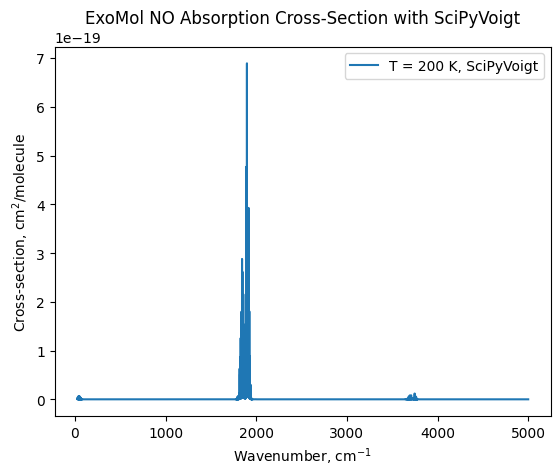

Cross sections plot saved.
Cross sections file saved.


In [65]:
t = Timer()
t.start()

# Depends on how many cores you want to utilise.
# Reserve 64 cores for our script.
max_processors = 64       
pool = multiprocessing.Pool(processes=max_processors)
f_list = []
f = pool.apply_async(get_results, [read_path])
f_list.append(f)
if len(f_list) >= max_processors:
    for f in f_list:
        f.get()
        del f_list[:]

t.end()

In [1]:
# Test

## Plot Different Profile At Same T and P

In [3]:
T=300
wn_grid, Q, A, v, Ep, Epp, gp, Jpp, gamma_L, n_air = part_linelist(states_df, trans_df, broad_df)
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
#coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
alpha = Doppler_HWHM (v, mass, T)
gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)

NameError: name 'part_linelist' is not defined

In [ ]:
xsec_g = exomol_cross_section_Gaussian(wn_grid, v, alpha, coef)
xsec_l = exomol_cross_section_Lorentzian(wn_grid, v, gamma, coef)
xsec_sv = exomol_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, coef)
xsec_swv = exomol_cross_section_scipy_wofz_Voigt(wn_grid, v, alpha, gamma, coef)
xsec_wv = exomol_cross_section_width_Voigt(wn_grid, v, alpha, gamma, coef)
xsec_pv = exomol_cross_section_pseudo_Voigt(wn_grid, v, alpha, gamma, coef)        
xsec_pfv = exomol_cross_section_pseudo_FWHM_Voigt(wn_grid, v, alpha, gamma, coef)

In [ ]:
plot_xsec(wn_grid, xsec_g, database, 'Gaussian')
plot_xsec(wn_grid, xsec_l, database, 'Lorentzian')
plot_xsec(wn_grid, xsec_sv, database, 'SciPyVoigt')
plot_xsec(wn_grid, xsec_swv, database, 'SciPyWofzVoigt')
plot_xsec(wn_grid, xsec_wv, database, 'WidthVoigt')
plot_xsec(wn_grid, xsec_pv, database, 'PseudoVoigt')
plot_xsec(wn_grid, xsec_pfv, database, 'PseudoFWHMVoigt')

In [ ]:
wn = wn_grid
fig, ax = plt.subplots()
ax.plot(wn, xsec_g, label='Gaussian profile')
ax.plot(wn, xsec_l, label='Lorentzian profile')
ax.plot(wn, xsec_sv, label='SciPy Voigt profile')
ax.plot(wn, xsec_swv, label='SciPy Wofz Voigt profile')
ax.plot(wn, xsec_wv, label='Width Voigt profile')
ax.plot(wn, xsec_pv, label='Pseudo Voigt profile')
ax.plot(wn, xsec_pfv, label='Pseudo FWHM Voigt profile')
ax.set_xlabel('Wavenumber, cm$^{-1}$')
ax.set_ylabel('Cross-section, cm$^{2}$/molecule')
ax.set_title(database+' Database '+molecule+' '+abs_emi+' Cross-Section At T = '+str(T)+'K and P = '+str(P)+'bar')
ax.legend() 
plots_foldername = saveplots+molecule+'/'+database+'/'
if os.path.exists(plots_foldername):
    pass
else:
    os.makedirs(plots_foldername, exist_ok=True)    
plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'-'+str(max_wn)+'cm-1__'
            +database+'__'+abs_emi+'.png', dpi=500)
plt.show()
print('Cross sections plot saved.')


## Plot At Different T With The Same Line Profile

In [ ]:
profile = 'SciPyVoigt'
wn = wn_grid
plt.figure(figsize=(12,8), dpi=500)
fig, ax = plt.subplots()

T = 800
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
#coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
alpha = Doppler_HWHM (v, mass, T)
gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
xsec_sv = exomol_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, coef)
ax.plot(wn, xsec_sv, linewidth=1, label='T = 800 K')

T = 600
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
#coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
alpha = Doppler_HWHM (v, mass, T)
gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
xsec_sv = exomol_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, coef)
ax.plot(wn, xsec_sv, linewidth=1, label='T = 600 K')

T = 400
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
#coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
alpha = Doppler_HWHM (v, mass, T)
gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
xsec_sv = exomol_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, coef)
ax.plot(wn, xsec_sv, linewidth=1, label='T = 400 K')

T = 200
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
#coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
alpha = Doppler_HWHM (v, mass, T)
gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
xsec_sv = exomol_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, coef)
ax.plot(wn, xsec_sv, linewidth=1, label='T = 200 K')

T = 100
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
#coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
alpha = Doppler_HWHM (v, mass, T)
gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
xsec_sv = exomol_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, coef)
ax.plot(wn, xsec_sv, linewidth=1, label='T = 100 K')

T = 50
coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
#coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
alpha = Doppler_HWHM (v, mass, T)
gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
xsec_sv = exomol_cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, coef)
ax.plot(wn, xsec_sv, linewidth=1, label='T =   50 K')

ax.set_xlabel('Wavenumber, cm$^{-1}$')
ax.set_ylabel('Cross-section, cm$^{2}$/molecule')
ax.set_title(database + ' Database ' + molecule + ' ' + abs_emi +' Cross-Section With ' + profile)  
ax.legend() 
plots_foldername = saveplots+molecule+'/'+database+'/'
if os.path.exists(plots_foldername):
    pass
else:
    os.makedirs(plots_foldername, exist_ok=True)    
plt.savefig(plots_foldername+molecule+'__'+str(min_wn)+'-'+str(max_wn)+'cm-1__'
            +database+'__'+abs_emi+'__'+profile+'.png', dpi=500)
plt.show()
print('Cross sections plot saved.')
